In [1]:
!pip install --upgrade --no-dependencies llm_bhasa

# LLM Training

## Training - Direct through library

In [2]:
from llm_bhasa.harmony import training
training.train?

Model cannot be loaded as model_and_optimizer.pth doesnt exist
Device: cuda
##============== Model Summary =========================##
# Total number of parameters: 163,009,536
# Token embedding layer shape: torch.Size([50257, 768])
# Output layer shape: torch.Size([50257, 768])
# Number of trainable parameters considering weight tying: 124,412,160
# Total size of the model: 621.83 MB
##======================================================##


Total filepaths: len['the-verdict.txt', 'gutenberg_books/1342.txt', 'gutenberg_books/84.txt', 'gutenberg_books/1661.txt']
Ep 1 (Step 000000): Train loss 11.946, Val loss 11.964
Every effort moves you, and                                                
Ep 2 (Step 000100): Train loss 7.194, Val loss 8.380
Every effort moves you, and I am    ” ” ” ” ” ” ” ” ” ” ” ” ” ” 
Ep 3 (Step 000200): Train loss 6.590, Val loss 8.195
Every effort moves you, and                                                
Ep 4 (Step 000300): Train loss 6.071, Val loss 8.021
Every effort moves you, and I am sure, and I am sure, and I am not                                   
Ep 5 (Step 000400): Train loss 5.487, Val loss 7.952
Every effort moves you, and I was a    ” “I have ” ” ” ” ” ” ” ” ” ” ” 
Ep 6 (Step 000500): Train loss 4.993, Val loss 7.984
Every effort moves you  ” “I have been ” ” ” ” ” ” ” ” ” ” ” ” ” 
Ep 7 (Step 000600): Train loss 4.252, Val loss 7.967
Every effort moves you   ” “I have you.” “I am n

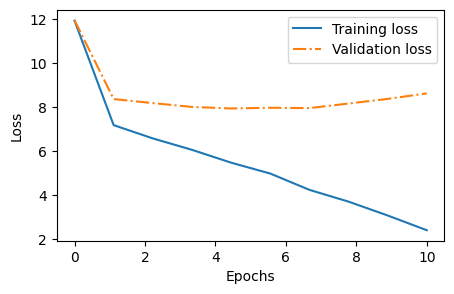

In [3]:
%%time

from llm_bhasa.harmony import training
training.train(num_epochs=10, eval_freq=100)  # Print eval every 100 steps

## Training - Lets break down

Below we will break above single line function into building blocks to have more fine grain control

In [4]:
import os
import pandas as pd

import torch
import torch.nn as nn
from llm_bhasa.harmony import config
from llm_bhasa.harmony import model
from llm_bhasa.harmony import training
from llm_bhasa.harmony import data, dataset

### Download data

In [5]:
gutenberg_book_ids = range(50000)

#### Filter only availiable book_ids

In [6]:
bookkeep_available_book_ids_file = "/kaggle/input/download-gutenberg-book-dataset/guthenberg_bookkeeper.csv"

if os.path.exists(bookkeep_available_book_ids_file):
    df_bookkeep = pd.read_csv(bookkeep_available_book_ids_file)
    df_bookkeep = df_bookkeep[df_bookkeep['status'] == True]
    gutenberg_book_ids = df_bookkeep['book_id'].tolist()

print(f"Total book_ids after taking only available files: {len(gutenberg_book_ids)}")

Total book_ids after taking only available files: 47719


#### Filter processed book_ids

In [7]:
bookkeep_processed_book_ids_file = "/kaggle/input/training-llm/guthenberg_bookkeeper.csv"

if os.path.exists(bookkeep_processed_book_ids_file):
    df_bookkeep = pd.read_csv(bookkeep_processed_book_ids_file)

    # Removing book_id which are already processed
    gutenberg_book_ids = list(set(gutenberg_book_ids) - set(df_bookkeep['book_id'].tolist()))

print(f"Total book_ids after removing processed files: {len(gutenberg_book_ids)}")

Total book_ids after removing processed files: 47719


#### Limit files to process

Due to Kaggle time limitation we can only keep kernel alive for certain amount of time, so we will limit the number of books to be processed

In [8]:
limit = 1000
# gutenberg_book_ids_train = gutenberg_book_ids[0: limit]
gutenberg_book_ids_train = gutenberg_book_ids[2000: 2000 + limit]

#### URL prepration

In [9]:
# #comment/uncomment to download gutenberg directly from websites
# filepaths = data.download_sample_text(gutenberg_book_ids=gutenberg_book_ids_train, verbose=False, njobs=4)
# print(f"Total Downloaded Books: {len(filepaths)}")

In [10]:
# #comment/uncomment to generate URI, which will be downloaded later
base_url = "https://www.gutenberg.org/files/{}/{}-0.txt"
fileurls = [base_url.format(book_id, book_id) for book_id in gutenberg_book_ids_train]
print(f"Total Downloaded Books: {len(fileurls)}")

Total Downloaded Books: 1000


### Data Loaders

In [11]:
model_filepath = "/kaggle/working/model_and_optimizer.pth"
config_train = config.GPT_CONFIG_124M
context_len = config_train['context_length']

In [12]:
train_data, val_data = training.split_data(fileurls, train_ratio=0.90) # Limit number of files

In [13]:
# Creating data loader for both train and validation
train_loader = dataset.create_dataloader(train_data, batch_size=2, max_length=context_len, stride=context_len,
                                         drop_last=True, num_workers=0)

val_loader = dataset.create_dataloader(val_data, batch_size=2, max_length=context_len, stride=context_len,
                                        drop_last=False, num_workers=0)

## Since number of files which wikll be downloaded will be huge, this step can be skipped
# for cntr, data in enumerate(train_loader):
#     pass
# print(f"Total batches: {cntr}")

### Model Defination

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [15]:
config_train

{'vocab_size': 50257,
 'context_length': 1024,
 'emb_dim': 768,
 'n_heads': 12,
 'n_layers': 12,
 'drop_rate': 0.1,
 'qkv_bias': False}

define our model based on passed configuration, different configuration can also be passed

In [16]:
model_llm = model.LLMModel(config_train)

In [17]:
!rm -rf ~/.cache/huggingface/hub  -- delete any cache

### Loading Previously trained model from HuggingFace
we dont want to train from scratch, lets load previously trained model of same config from huggingface 
<br/>

<b>repo</b> - https://huggingface.co/pankajr141/llm_bhasa_v1

In [18]:
repo = "pankajr141"
modelname = "llm_bhasa_v1"

repo_url = f"{repo}/{modelname}"
repo_url

'pankajr141/llm_bhasa_v1'

In [19]:
# Load from hugging face
model_llm = model.LLMModel.from_pretrained(repo_url)

config.json:   0%|          | 0.00/174 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/702M [00:00<?, ?B/s]

In [20]:
# model_llm = model.load_model(model_llm, model_filepath) # Resuming training by loading previously trained model
model.print_model_information(model_llm)

if torch.cuda.device_count() > 1:
    model_llm = nn.DataParallel(model_llm)

model_llm.to(device)                                    # Assigning GPU/CPU to model
print("Model Defined")

##============== Model Summary =========================##
# Total number of parameters: 163,009,536
# Token embedding layer shape: torch.Size([50257, 768])
# Output layer shape: torch.Size([50257, 768])
# Number of trainable parameters considering weight tying: 124,412,160
# Total size of the model: 621.83 MB
##======================================================##
Model Defined


### Additional Defination

In [21]:
optimizer = torch.optim.AdamW(model_llm.parameters(), lr=0.0004, weight_decay=0.1)

In [22]:
from llm_bhasa.harmony import tokenizer as tokenizer_lib
tokenizer = tokenizer_lib.get_tokenizer()
tokenizer

<Encoding 'gpt2'>

### Lets train

In [23]:
%%time

num_epochs = 1
# Training LLM model from scratch
train_losses, val_losses, tokens_seen = training.train_model(model_llm, 
                                                             train_loader,
                                                             val_loader, 
                                                             optimizer, 
                                                             device,
                                                             num_epochs=num_epochs,
                                                             eval_freq=500,   # Loss will be printed every 500 steps
                                                             eval_iter=50,    # Number of batches to use for each evaluation
                                                             start_context="Every effort moves you", 
                                                             tokenizer=tokenizer)
model.save_model(model_llm, optimizer, model_filepath)

Ep 1 (Step 000000): Train loss 3.672, Val loss 4.265
Ep 1 (Step 000500): Train loss 3.257, Val loss 4.316
Ep 1 (Step 001000): Train loss 3.345, Val loss 4.221
Ep 1 (Step 001500): Train loss 3.698, Val loss 4.555
Ep 1 (Step 002000): Train loss 3.391, Val loss 4.257
Ep 1 (Step 002500): Train loss 3.427, Val loss 4.165
Ep 1 (Step 003000): Train loss 3.621, Val loss 4.421
Ep 1 (Step 003500): Train loss 3.401, Val loss 4.197
Ep 1 (Step 004000): Train loss 3.559, Val loss 4.267
Ep 1 (Step 004500): Train loss 3.582, Val loss 4.223
Ep 1 (Step 005000): Train loss 3.491, Val loss 4.142
Ep 1 (Step 005500): Train loss 3.531, Val loss 4.184
Ep 1 (Step 006000): Train loss 3.561, Val loss 4.175
Ep 1 (Step 006500): Train loss 3.705, Val loss 4.319
Ep 1 (Step 007000): Train loss 3.714, Val loss 4.322
Ep 1 (Step 007500): Train loss 3.692, Val loss 4.362
Ep 1 (Step 008000): Train loss 3.543, Val loss 4.244
Ep 1 (Step 008500): Train loss 3.566, Val loss 4.224
Ep 1 (Step 009000): Train loss 3.738, Val loss

In [24]:
# model_llm.to(device)
# training.evaluate_model(model_llm, train_loader, val_loader, device, 50)

### Plot Results Train vs Validation

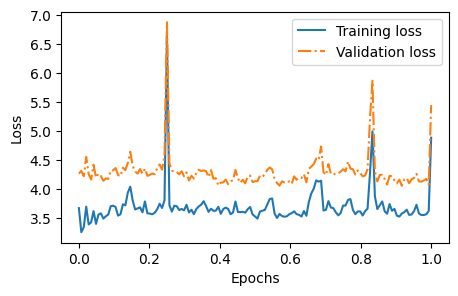

In [25]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
training.plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

### Generate some samples

In [26]:
from llm_bhasa.harmony import generator

model_llm.eval()  # Disable dropout during evaluation
model_llm.to(device)

context_len = config_train['context_length']

In [27]:
def generate_text(start_context):
    tokenizer = tokenizer_lib.get_tokenizer()
    encoded = tokenizer_lib.text_to_token_ids(start_context, tokenizer).to(device)
    token_ids  = generator.generate(model=model_llm, idx=encoded, max_new_tokens=50, context_size=context_len)
    decoded_text = tokenizer_lib.token_ids_to_text(token_ids, tokenizer)
    return decoded_text.replace("\n", " ")

In [28]:
generate_text("Hello, I am")

'Hello, I am glad to have you,” said Nora.\r \r \r “You are very angry,” said Nora. “You are very angry, and I am not so angry.”\r \r \r '

In [29]:
generate_text("Lets start")

'Lets start.\r \r \r \r “I am,” said Nora. “I am glad to see you.”\r \r \r “You are,” said Nora. “I am'

In [30]:
generate_text("How is your")

'How is your father,” said Nora.\r \r “I am glad to see you,” said Nora. “I am glad to see you.”\r \r \r “You are very fond of me'

## Deploy to Huggingface

In [31]:
# from huggingface_hub import notebook_login
# notebook_login()

In [32]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
huggingfacetoken = user_secrets.get_secret("huggingface")

from huggingface_hub.hf_api import HfFolder
HfFolder.save_token(huggingfacetoken)

Depending on whether multiple GPU are availaible model_llm can be instance of DataParallel which can cause issue while saving and loading model, hence sorting the issue.

In [33]:
from torch.nn.parallel.data_parallel import DataParallel
if isinstance(model_llm, DataParallel):
    print("model is instance of DataParallel, changing the class")
    model_llm = model_llm.module

In [34]:
# save locally
model_llm.save_pretrained(modelname)

# push to the hub
model_llm.push_to_hub(repo_url)

# Load from hugging face
# model_llm = model.LLMModel.from_pretrained(repo_url)

model.safetensors:   0%|          | 0.00/702M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/pankajr141/llm_bhasa_v1/commit/9ff74cbb7b5a628d624f18bd9103019959c206fb', commit_message='Push model using huggingface_hub.', commit_description='', oid='9ff74cbb7b5a628d624f18bd9103019959c206fb', pr_url=None, repo_url=RepoUrl('https://huggingface.co/pankajr141/llm_bhasa_v1', endpoint='https://huggingface.co', repo_type='model', repo_id='pankajr141/llm_bhasa_v1'), pr_revision=None, pr_num=None)

remove model outputfile

In [35]:
if os.path.exists(model_filepath):
    print(f"Removing: {model_filepath}")
    os.remove(model_filepath)

Removing: /kaggle/working/model_and_optimizer.pth


## BookKeep for future training

In [36]:
# bookkeep_processed_book_ids_file
df_bookkeep_delta = pd.DataFrame([{'book_id': book_id} for book_id in gutenberg_book_ids[0:3000]])

if os.path.exists(bookkeep_processed_book_ids_file):
    df_bookkeep = pd.read_csv(bookkeep_processed_book_ids_file)
    df_bookkeep_delta = pd.concat([df_bookkeep, df_bookkeep_delta], axis=0)
    
df_bookkeep_delta.to_csv(os.path.basename(bookkeep_processed_book_ids_file), index=False)
df_bookkeep_delta

,book_id
0,1
1,3
2,7
3,9
4,10
...,...
2995,7467
2996,7468
2997,7469
2998,7472


#